In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
import scipy as sc, scipy.io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib.colors import LightSource

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

%matplotlib inline

In [2]:
idealf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')
ideal = idealf['Bathymetry'][:]
realf = nc.Dataset('/ocean/imachuca/Canyons/runs_mackenzie_canyon/prepare_real_bathy/real_bathy_for_agrif_fix.nc')
real = realf['Bathymetry'][:]
coordsf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_for_agrif.nc')
maskfi = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/mesh_mask.nc')
maskfr = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_base/mesh_mask.nc')

In [3]:
nav_lat = maskfr['nav_lat'][:]
nav_lon = maskfr['nav_lon'][:]

nav_lat.min(), nav_lat.max(), nav_lon.min(), nav_lon.max()

(68.40502, 72.69578, -150.76591, -132.92242)

# Figure - Map

https://matplotlib.org/basemap/users/stere.html

https://matplotlib.org/basemap/api/basemap_api.html

https://bitbucket.org/canyonsubc/mackenzie_canyon/src/default/tools/functions_plot.py

https://bitbucket.org/canyonsubc/analysis_mackenzie_canyon/src/default/notebooks/presentations/

https://www.kennethmoreland.com/color-maps/


In [4]:
#x_region, y_region, z_region = functions_plot.def_regionG(xl=-141.6, xr=-135.7, yb=69.1, yt=70.9)
#X, Y = np.meshgrid(x_region, y_region)

#ax2 = fig.add_subplot(1, 2, 2, projection='3d')
#ls = LightSource(270, 45)
#rgb = ls.shade(z_region, cmap=cmap, vert_exag=0.8, blend_mode='overlay', vmin=-3865, vmax=2370)
#surf = ax2.plot_surface(X, Y, z_region, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=False)
#ax2.set_xticks([])
#ax2.set_yticks([])
#ax2.grid(True)
#ax2.view_init(elev=40, azim=90)

In [5]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [6]:
# https://superdevresources.com/tools/color-shades#8b7765
list_ocean = ['#f7fcf0','#a8ddb5','#7bccc4','#4eb3d3','#2b8cbe','#0868ac','#084081'] #2,3 - ,'#e0f3db','#ccebc5'
colour_list = list_ocean
cmap = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

levels_p = np.concatenate((np.arange(0, 80, 20), np.linspace(80, 5500, 30)), axis=0)
levels_c = [40, 80, 220, 506, 1300]

In [7]:
def plot_arctic(ax, cmap, levels_p, levels_c, nav_lon, nav_lat):
    lw, ms, fs_numb, fs_str, fs = 2.5, 12, 25, 30, 25
    
    m = Basemap(width=7000000, height=7000000, resolution='i',projection='stere',
                  lat_ts=90, lat_0=90, lon_0=-138., ax=ax)
    
    m.drawcoastlines()
    m.drawlsmask(land_color='#8b7765', ocean_color='#9DA2AB', lakes=True)
    m.fillcontinents(color='#8b7765', alpha=1, zorder=3)
    m.drawcountries(linewidth=2, linestyle='-', color='#4C4138', zorder=4)
    m.drawstates(linewidth=2, linestyle='--', color='#4C4138', zorder=4)
    m.drawparallels(np.arange(-80.,81.,4.0), labels=[True,False,False,False], 
                    color='#D9CFC1', fontsize=fs_numb, zorder=4)#0.5
    m.drawmeridians(np.arange(-180.,181.,40.0), labels=[False,False,False,True], 
                    color='#D9CFC1', fontsize=fs_numb, zorder=4)#1.5
    
    ibcao_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/data/IBCAO_V3_30arcsec_RR.grd')
    x = ibcao_file.variables['x'][:]
    y = ibcao_file.variables['y'][:]
    z = ibcao_file.variables['z'][:]
    
    X, Y = np.meshgrid(x, y) 
    lon, lat = m(X, Y) 
    z_positive = -1 * z
    p = m.contourf(lon, lat, z_positive, cmap=cmap, levels=levels_p, zorder=1)
    c = m.contour(lon, lat, z_positive, levels=levels_c, colors='k', alpha=0.3, zorder=2)
    
    cd, lwd = 'k', 2.0
    nav_lon_d, nav_lat_d = m(nav_lon, nav_lat)
    ax.plot((nav_lon_d[0, 0], nav_lon_d[0, -1]), (nav_lat_d[0, 0], nav_lat_d[0, -1]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[0, 0], nav_lon_d[-1, 0]), (nav_lat_d[0, 0], nav_lat_d[-1, 0]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[-1, -1], nav_lon_d[-1, 0]), (nav_lat_d[-1, -1], nav_lat_d[-1, 0]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[-1, -1], nav_lon_d[0, -1]), (nav_lat_d[-1, -1], nav_lat_d[0, -1]), c=cd, lw=lwd, zorder=5)
    #ax.set_title('a)', fontsize=30, fontdict={'horizontalalignment': 'left'})
    ax.set_ylabel('Latitude', fontsize=fs_str, labelpad=30)
    ax.set_xlabel('Longitude', fontsize=fs_str, labelpad=30)
    print('plot_arctic')
    
    return ax

In [8]:
def plot_3d(ax):
    x_region, y_region, z_region = functions_plot.def_regionS(xl=-1600e3, xr=-1300e3, yb=1500e3, yt=1780e3)
    #x_region, y_region, z_region = functions_plot.def_regionS(xl=-1698e3, xr=-1102e3, yb=1348e3, yt=19575e2)
    X, Y = np.meshgrid(x_region, y_region)
    ls = LightSource(270, 45)
    
    rgb = ls.shade(z_region, cmap=cm.gist_earth, vert_exag=0.8, blend_mode='overlay', vmin=-3000, vmax=1000)
    surf = ax.plot_surface(X, Y, z_region, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=False)
    ax.view_init(elev=40)
    
    ax.text(-1400000, 1750000, 500, 'Canadian\nArctic\nCoast', None, fontsize=25)
    ax.text(-1580000, 1680000, -250, 'Mackenzie\nCanyon', None, fontsize=25)
    ax.text(-1600000, 1550000, -2350, 'Deep\nOcean', None, fontsize=25)
    
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_zticks([])
    ax.grid(True)
    ax.set_zlabel('Height [m]', fontsize=25, labelpad=30)
    ax.tick_params(axis='both', which='both', length=0, labelsize=25)
    ax.zaxis.set_ticks([500, 0, -500, -1500, -2500])
    
    #ax.set_title('b)', fontsize=30, fontdict={'horizontalalignment': 'left'})
    
    print('plot_3d')
    return ax

In [44]:
def plot_region(ax, cmap, levels_p, levels_c, nav_lon, nav_lat):
    
    lw, ms, fs_numb, fs_str, fs = 2.5, 12, 25, 30, 25

    ticks0 = np.concatenate((np.array([0, 80]), np.arange(1000, np.max(levels_p)+1000, 1000)), axis=0)
    ticks = [ int(x) for x in ticks0 ]

    #width=1600000, height=650000
    m = Basemap(width=1300000, height=700000, resolution='i',projection='stere',
                  lat_ts=70, lat_0=70.5, lon_0=-138., ax=ax)
    m.drawcoastlines()
    m.drawrivers()
    #m.drawlsmask(land_color='#8b7765', ocean_color='#9DA2AB', lakes=True)
    m.fillcontinents(color='#8b7765', alpha=1, zorder=3)
    m.drawcountries(linewidth=2, linestyle='-', color='#4C4138', zorder=4)
    m.drawstates(linewidth=2, linestyle='--', color='#4C4138', zorder=4)
    m.drawparallels(np.arange(-80.,81.,2.0), labels=[True,False,False,False], 
                    color='#D9CFC1', fontsize=fs_numb, zorder=4)#0.5
    m.drawmeridians(np.arange(-180.,181.,5.0), labels=[False,False,False,True], 
                    color='#D9CFC1', fontsize=fs_numb, zorder=4)#1.5
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

    x_region, y_region, z_region = functions_plot.def_regionG(xl=-165, xr=-115, yb=66, yt=74)
    X, Y = np.meshgrid(x_region, y_region) 
    lon, lat = m(X, Y) 
    z_positive = -1 * z_region

    p = m.contourf(lon, lat, z_positive, cmap=cmap, levels=levels_p, zorder=1)
    c = m.contour(lon, lat, z_positive, levels=levels_c, colors='k', alpha=0.3, zorder=2)
    #plt.clabel(c, inline=1, fontsize=fs_numb, fmt='%1.f', inline_spacing=16)
    cbar = m.colorbar(p,location='right',pad="3%")
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(ticks)
    cbar.set_label('Depth [m]', fontsize=fs_str, labelpad=30)
    cbar.ax.tick_params(labelsize=fs_numb)
    ax.set_ylabel('Latitude', fontsize=fs_str, labelpad=75)
    ax.set_xlabel('Longitude', fontsize=fs_str, labelpad=40)

    a='center'

    ax.annotate('Barrow\nCanyon', xy=(m(-152.8, 72.1)), xytext=(m(-150, 72.8)), 
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5), fontsize=fs, va=a, ha=a)
    ax.annotate('Mackenzie\nCanyon', xy=(m(-138.5, 69.5)), xytext=(m(-139, 68.0)),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5), fontsize=fs, va=a, ha=a)
    ax.annotate('Tuktoyaktuk\nPeninsula', xy=(m(-131.5, 69.5)), xytext=(m(-128.5, 68.5)),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5), fontsize=fs, va=a, ha=a)
    ax.annotate('Herschel\nIsland', xy=(m(-139.4, 69.5)), xytext=(m(-142.5, 68.3)),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5), fontsize=fs, va=a, ha=a)
    ax.annotate('Amundsen\nGulf', xy=(m(-125.8, 71.1)), fontsize=fs, va=a, ha=a)
    ax.annotate('Mackenzie\nShelf', xy=(m(-130.7, 70.5)), fontsize=fs, va=a, ha=a, rotation=0)#26
    ax.annotate('Beaufort\nShelf', xy=(m(-144.5, 70.3)), fontsize=fs, va=a, ha=a, rotation=0)#335
    ax.annotate('Mackenzie\nDelta', xy=(m(-134.5, 69.4)), xytext=(m(-131.5, 68.0)), 
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5), fontsize=fs, va=a, ha=a)
#     ax.annotate('Mackenzie\nRiver', xy=(m(-132, 68.2)), fontsize=fs, va=a, ha=a)

    lons_mooring = [-139.983, -136.817, -138.383, -138.183, -127.315, -128.45, -134.485, -138.613]
    lats_mooring = [70.533, 70.55, 69.9, 69.517, 70.767, 71.48, 70.962, 69.972]
    name_mooring = ['A', 'B', 'C', 'D', 'SS1', 'SS2', 'SS3', 'SS4']
    
    # for Amy's presentation
    coords_eval = [-139.60871666666668, 70.70343333333334]
    xmd, ymd = m(coords_eval[0], coords_eval[1])
    ax.scatter(xmd, ymd, c='k', marker='x', s=100)
    x,y= m(coords_eval[0]+0.5, coords_eval[1]+0.2)
    ax.annotate('model\nevaluation', xy=(x, y), fontsize=fs_str*0.65, va='center', ha='left')
    #
    
#     for xm, ym, name in zip(lons_mooring, lats_mooring, name_mooring):
#         xmd, ymd = m(xm, ym)
#         if name == 'A' or name == 'B' or name == 'C' or name == 'D':
#             ax.scatter(xmd, ymd, c='k', marker='x', s=100)
#             xmd, ymd = m(xm+0.6, ym-0.05)
#             ax.annotate(name, xy=(xmd, ymd), fontsize=fs_str, va='center', ha='center')
#         else:
#             ax.scatter(xmd, ymd, c='k', marker='o', s=80)
#             xmd, ymd = m(xm-1.1, ym+0.05)
#             ax.annotate(name, xy=(xmd, ymd), fontsize=fs_str, va='center', ha='center')
    
    cd, lwd = 'k', 3.5
    nav_lon_d, nav_lat_d = m(nav_lon, nav_lat)
    ax.plot((nav_lon_d[0, 0], nav_lon_d[0, -1]), (nav_lat_d[0, 0], nav_lat_d[0, -1]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[0, 0], nav_lon_d[-1, 0]), (nav_lat_d[0, 0], nav_lat_d[-1, 0]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[-1, -1], nav_lon_d[-1, 0]), (nav_lat_d[-1, -1], nav_lat_d[-1, 0]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[-1, -1], nav_lon_d[0, -1]), (nav_lat_d[-1, -1], nav_lat_d[0, -1]), c=cd, lw=lwd, zorder=5)
    #ax.set_title('c)', fontsize=30, fontdict={'horizontalalignment': 'left'})

    print(nav_lon_d[0, 0], nav_lon_d[-1, -1], nav_lon_d[0, -1], nav_lon_d[-1, 0])
    
    print(nav_lat_d[0, 0], nav_lat_d[-1, -1], nav_lat_d[0, -1], nav_lat_d[-1, 0])                                                        
    
    #plt.show()
    print('plot_region')
    return ax

plot_arctic
plot_3d
850493.4649441661 209188.80044422374 248785.5210399942 809904.6611625807
211501.6928481897 538911.0111347906 149368.472807935 600599.7491981251
plot_region
test


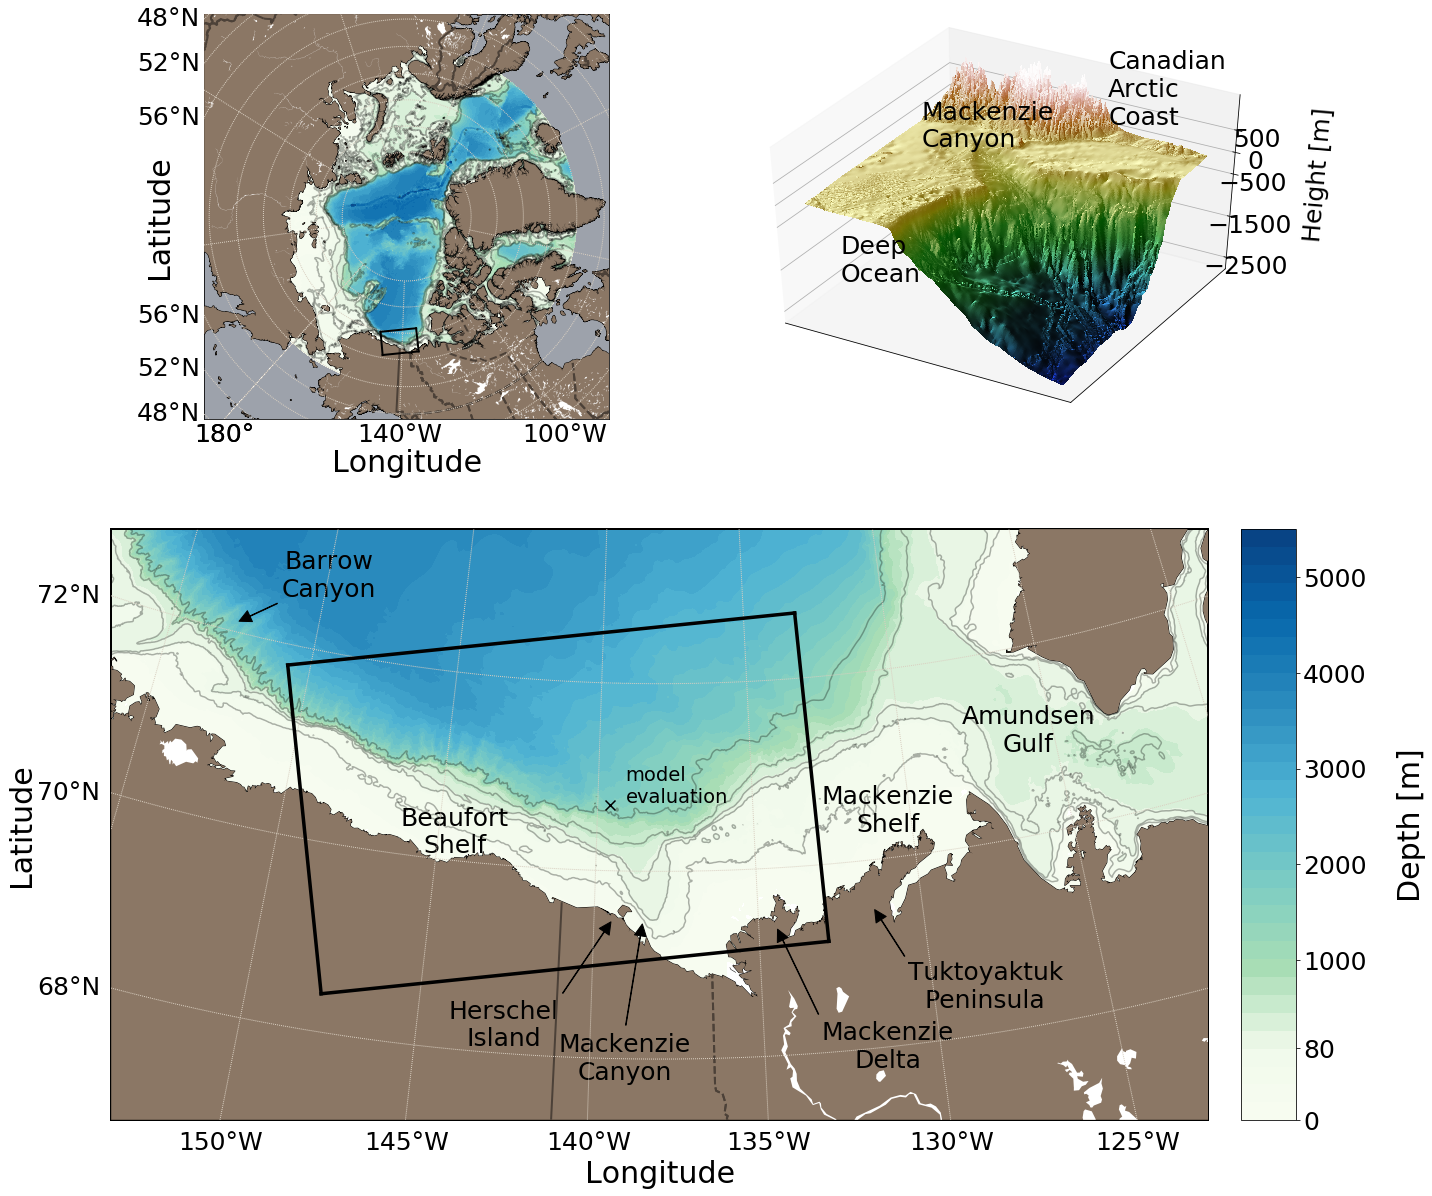

In [46]:
fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[3,6])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[1, :])

ax1 = plot_arctic(ax1, cmap, levels_p, levels_c, nav_lon, nav_lat)
ax2 = plot_3d(ax2)
ax3 = plot_region(ax3, cmap, levels_p, levels_c, nav_lon, nav_lat)

gs.tight_layout(fig)
gs.update(wspace=0.005, hspace=0.001)
fig.savefig('./map_Beaufort_Amy.png', dpi=100, bbox_inches='tight')
print('test')